# Imports

In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Data importing

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')

# Data exploration

In [ ]:
train.head()

,ID,Label,Statement,Subject,Speaker,Speaker's Job Title,State,Party,Barely True Count,False Count,Half True Count,Mostly True Count,Pants on Fire,Context
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
#Let's get the dataset lenght
len(train)

10240

In [ ]:
#Is there any other different value than neutral, negative and positive?
train['Label'].unique()

array(['FALSE', 'half-true', 'mostly-true', 'TRUE', 'barely-true',
       'pants-fire'], dtype=object)

In [ ]:
#How's distributed the dataset? Is it biased?
train.groupby('Label').nunique()

,ID,Statement,Subject,Speaker,Speaker's Job Title,State,Party,Barely True Count,False Count,Half True Count,Mostly True Count,Pants on Fire,Context
Label,,,,,,,,,,,,,
FALSE,1995,1988,1036,934,400,49,18,30,30,29,27,20,1173
TRUE,1676,1674,835,842,386,49,15,30,30,29,27,18,1000
barely-true,1654,1654,923,813,340,50,14,29,30,29,27,20,951
half-true,2114,2112,1125,995,418,50,15,30,30,29,27,19,1167
mostly-true,1962,1962,1049,923,439,47,17,30,30,29,26,20,1149
pants-fire,839,839,506,425,202,46,14,30,30,28,26,19,542


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
#Let's keep only the columns that we're going to use
train = train[['Statement','Label']]
train.head()

,Statement,Label
0,Says the Annies List political group supports ...,FALSE
1,When did the decline of coal start? It started...,half-true
2,"Hillary Clinton agrees with John McCain ""by vo...",mostly-true
3,Health care reform legislation is likely to ma...,FALSE
4,The economic turnaround started at the end of ...,half-true


In [ ]:
#Is there any null value?
train["Statement"].isnull().sum()

0

In [ ]:
#Let's fill the only null value.
train["Statement"].fillna("No content", inplace = True)

In [ ]:
train["Statement"].isnull().sum()

0

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = train["Statement"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Says the Annies List political group supports third-trimester abortions on demand.',
 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
 'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
 'Health care reform legislation is likely to mandate free sex change surgeries.',
 'The economic turnaround started at the end of my term.']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['says', 'the', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'on', 'demand'], ['when', 'did', 'the', 'decline', 'of', 'coal', 'start', 'it', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'to', 'begin', 'in', 'president', 'george', 'bushs', 'administration'], ['hillary', 'clinton', 'agrees', 'with', 'john', 'mccain', 'by', 'voting', 'to', 'give', 'george', 'bush', 'the', 'benefit', 'of', 'the', 'doubt', 'on', 'iran'], ['health', 'care', 'reform', 'legislation', 'is', 'likely', 'to', 'mandate', 'free', 'sex', 'change', 'surgeries'], ['the', 'economic', 'turnaround', 'started', 'at', 'the', 'end', 'of', 'my', 'term'], ['the', 'chicago', 'bears', 'have', 'had', 'more', 'starting', 'quarterbacks', 'in', 'the', 'last', 'years', 'than', 'the', 'total', 'number', 'of', 'tenured', 'uw', 'faculty', 'fired', 'during', 'the', 'last', 'two', 'decades'], ['jim', 'dunnam', 'has', 'not', 'lived', 'in', 'the', 'district', 'he', 'repres

In [ ]:
len(data_words)

10240

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['says the annies list political group supports third trimester abortions on demand', 'when did the decline of coal start it started when natural gas took off that started to begin in president george bushs administration', 'hillary clinton agrees with john mccain by voting to give george bush the benefit of the doubt on iran', 'health care reform legislation is likely to mandate free sex change surgeries', 'the economic turnaround started at the end of my term']


In [ ]:
data = np.array(data)

In [ ]:
len(data)

10240

# Label encoding

As the dataset has labels 0, 1 ,2 ,3 ,4 and 5. We need to convert them to one hot vector.

0-   FALSE

1-   TRUE

2-   barely-true

3-   half-true

4-   mostly-true

5-   pants-fire

In [ ]:
labels = np.array(train['Label'])


In [ ]:
print (labels)

['FALSE' 'half-true' 'mostly-true' ... 'half-true' 'FALSE' 'pants-fire']


In [ ]:
l=[]
for i in labels:
  if i=="FALSE":
    l.append(0)
  elif i=="TRUE":
    l.append(1)
  elif i=="barely-true":
    l.append(2)
  elif i=="half-true":
    l.append(3)
  elif i=="mostly-true":
    l.append(4)
  elif i=="pants-fire":
    l.append(5)

y_final = np.array(l)

In [ ]:
print(y_final)

[0 3 4 ... 3 0 5]


In [ ]:
labels = tf.keras.utils.to_categorical(y_final, 6, dtype="float32")
# labels=y_final

In [ ]:
print (labels)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
len(labels)

10240

# Data sequencing and splitting


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  545   10 1498]
 [   0    0    0 ...  291 1022  167]
 [   0    0    0 ... 3350   10  386]
 ...
 [   0    0    0 ...   67  175  124]
 [   0    0    0 ... 2269    4 1573]
 [   0    0    0 ...    4 1760 1649]]


In [ ]:
len(tweets)

10240

In [ ]:
len(tweets[19])

200

In [ ]:
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

7680 2560 7680 2560


#Multi LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 100))
model1.add(layers.LSTM(73,return_sequences=True,dropout=0.5))
model1.add(layers.LSTM(51,return_sequences=True))
model1.add(layers.LSTM(37,return_sequences=True))
model1.add(layers.LSTM(19))
model1.add(layers.Dense(6,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         500000    
_________________________________________________________________
lstm_31 (LSTM)               (None, None, 73)          50808     
_________________________________________________________________
lstm_32 (LSTM)               (None, None, 51)          25500     
_________________________________________________________________
lstm_33 (LSTM)               (None, None, 37)          13172     
_________________________________________________________________
lstm_34 (LSTM)               (None, 19)                4332      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 120       
Total params: 593,932
Trainable params: 593,932
Non-trainable params: 0
_______________________________________________

In [ ]:
history = model1.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
240/240 [==============================] - 14s 40ms/step - loss: 1.7623 - accuracy: 0.2165 - val_loss: 1.7419 - val_accuracy: 0.2148
Epoch 2/100
240/240 [==============================] - 8s 35ms/step - loss: 1.7222 - accuracy: 0.2405 - val_loss: 1.7401 - val_accuracy: 0.2461
Epoch 3/100
240/240 [==============================] - 8s 34ms/step - loss: 1.6745 - accuracy: 0.2742 - val_loss: 1.7368 - val_accuracy: 0.2488
Epoch 4/100
240/240 [==============================] - 8s 35ms/step - loss: 1.6175 - accuracy: 0.3117 - val_loss: 1.7526 - val_accuracy: 0.2438
Epoch 5/100
240/240 [==============================] - 8s 34ms/step - loss: 1.5657 - accuracy: 0.3497 - val_loss: 1.7985 - val_accuracy: 0.2484
Epoch 6/100
240/240 [==============================] - 8s 34ms/step - loss: 1.5094 - accuracy: 0.3838 - val_loss: 1.8922 - val_accuracy: 0.2172
Epoch 7/100
240/240 [==============================] - 8s 35ms/step - loss: 1.4623 - accuracy: 0.4152 - val_loss: 1.8618 - val_accuracy

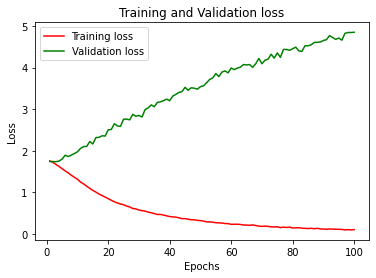

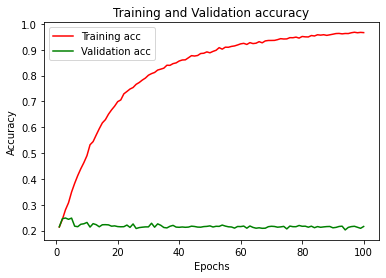

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred=model1.predict(X_test, batch_size=200, verbose=1)

13/13 [==============================] - 1s 19ms/step


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.24      0.20      0.22       504
           1       0.21      0.20      0.21       411
           2       0.21      0.20      0.20       438
           3       0.24      0.26      0.25       525
           4       0.18      0.16      0.17       486
           5       0.19      0.17      0.18       196

   micro avg       0.21      0.20      0.21      2560
   macro avg       0.21      0.20      0.20      2560
weighted avg       0.21      0.20      0.21      2560
 samples avg       0.20      0.20      0.20      2560



In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred.round())

0.204296875

RUC , AUC SCORE

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred.round())

0.524020576780606